In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import jarque_bera, norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox



In [3]:
# DOWNLOADING DATA
# the ticker symbol
ticker_symbol = "INR=X"
start_date = "2010-01-01" #the start date (took more or less 10 years, so 2015)


inr_data = yf.download(ticker_symbol, start=start_date)

# Display the first few rows to confirm the download
print(inr_data.head())

/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65590/3035607127.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  inr_data = yf.download(ticker_symbol, start=start_date)
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open Volume
Ticker          INR=X      INR=X      INR=X      INR=X  INR=X
Date                                                         
2010-01-01  46.610001  46.645000  46.400002  46.400002      0
2010-01-04  46.287998  46.610001  46.223000  46.610001      0
2010-01-05  46.119999  46.287998  46.088001  46.287998      0
2010-01-06  45.720001  46.180000  45.700001  46.147999      0
2010-01-07  45.688000  45.877998  45.557999  45.737999      0


In [4]:
# CALCULATING LOG-RETURNS
#r_t  = ln(P_t / P_(t-1))
inr_data['log_return'] = np.log(inr_data['Close'] / inr_data['Close'].shift(1))
inr_data.dropna(inplace=True) #removing NaN values that result from the shift operation

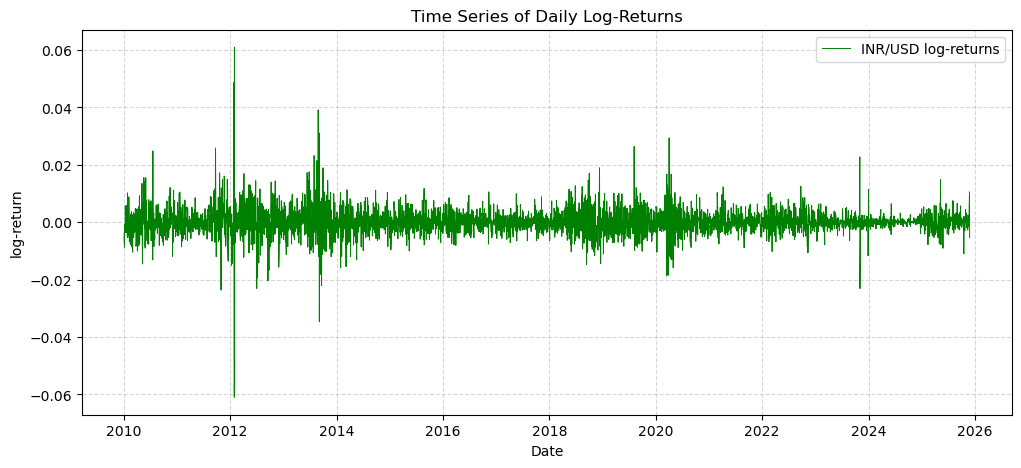

In [5]:
# PLOTTING LOG-RETURNS TIME SERIES 
plt.figure(figsize=(12, 5))
plt.plot(inr_data.index, inr_data['log_return'], label='INR/USD log-returns', color='green', linewidth=0.7)
plt.title('Time Series of Daily Log-Returns')
plt.ylabel('log-return')
plt.xlabel('Date')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.show()


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65590/1537104161.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')
/var/folders/4p/23m263753jx7n8lstr62j07h0000gn/T/ipykernel_65590/1537104161.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')


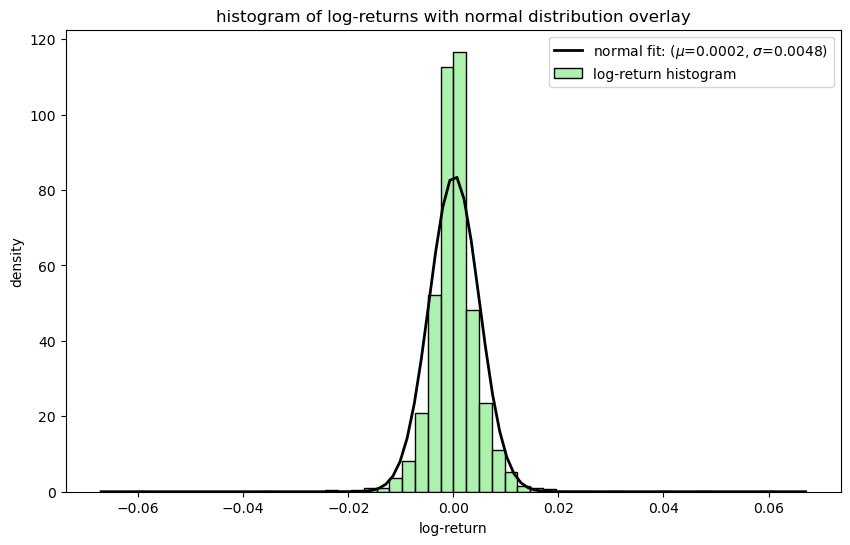

In [6]:
# HISTOGRAM OF LOG-RETURNS + NORMALITY TEST
returns = inr_data['log_return']

plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=50, kde=False, stat='density', color='lightgreen', label='log-return histogram')

#fitting a normal distribution to the data
mu, sigma = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)

#plotting the fitted normal distribution
plt.plot(x, p, 'k', linewidth=2, label=f'normal fit: ($\mu$={mu:.4f}, $\sigma$={sigma:.4f})')
plt.title('histogram of log-returns with normal distribution overlay')
plt.xlabel('log-return')
plt.ylabel('density')
plt.legend()
plt.show()


In [15]:
# JARQUE-BERA NORMALITY TEST
jb_test = jarque_bera(returns)
print('jarque-bera normality test')
print(f'JB statistic: {jb_test.statistic:.4f}')
print(f'p-value: {jb_test.pvalue:.4e}') #using scientific notation for small p-values

if jb_test.pvalue < 0.05:
    print('reject the null hypothesis of normal distribution (p-value < 0.05)')
else:
    print('cant reject the null hypothesis of normal distribution')
print('-'*30)

jarque-bera normality test
JB statistic: 112116.1360
p-value: 0.0000e+00
reject the null hypothesis of normal distribution (p-value < 0.05)
------------------------------


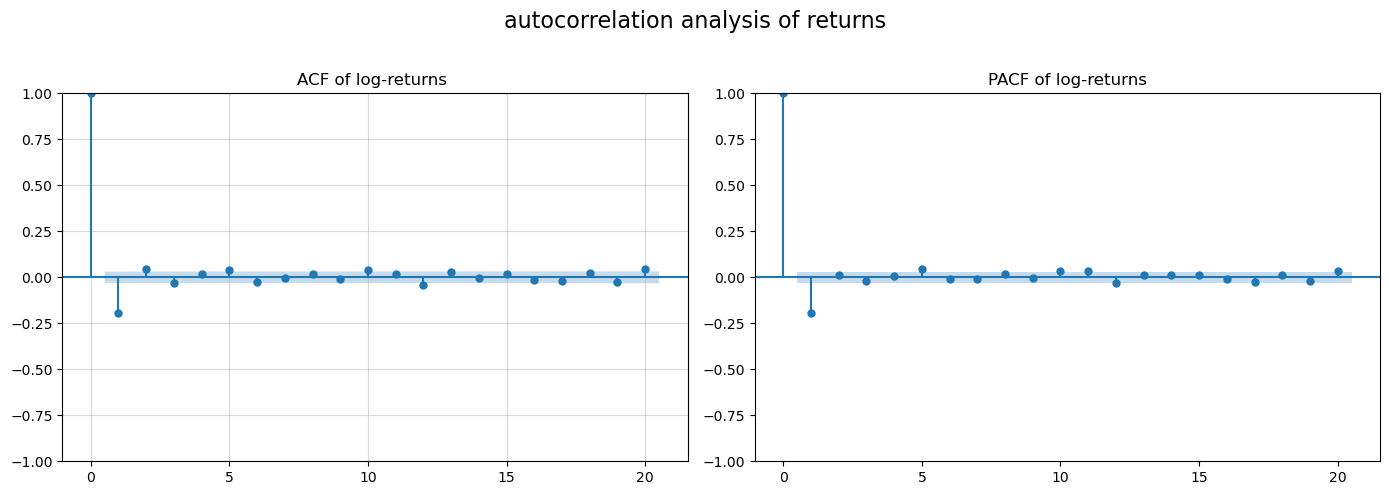

ljung-box test on log-returns
       lb_stat     lb_pvalue
10  184.852967  2.299639e-34
20  213.610461  2.241188e-34

*If p-values are high (>0.05), there is no significant autocorrelation*
------------------------------


In [16]:
# PLOTTING THE ACF FOR LOG-RETURNS AND SQUARED LOG-RETURNS
## 1. ACF and PACF for log-returns (r_t)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

#ACF 
plot_acf(returns, lags = 20, ax=axes[0], title='ACF of log-returns ')
axes[0].grid(True, alpha = 0.5)
#PACF
plot_pacf(returns, lags = 20, ax=axes[1], title='PACF of log-returns')
axes[0].grid(True, alpha =0.5)

plt.suptitle('autocorrelation analysis of returns', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Ljung-Box test for autocorrelation in returns
lb_test_r = acorr_ljungbox(returns, lags=[10,20], return_df=True)
print('ljung-box test on log-returns')
print(lb_test_r)
print('\n*If p-values are high (>0.05), there is no significant autocorrelation*')
print('-' * 30)

In [17]:
# Ljung-Box test for autocorrelation at Lag 1
lb_test_r_lag1 = acorr_ljungbox(returns, lags=[1], return_df=True)
print('\nLjung-Box test on log-returns for Lag 1:')
print(lb_test_r_lag1)


Ljung-Box test on log-returns for Lag 1:
      lb_stat     lb_pvalue
1  154.283521  2.008023e-35


In [ ]:
# The result for the Ljung-Box test at Lag 1 definitively confirms 
# that the negative spike you observed in the ACF/PACF plots is statistically significant.

In [ ]:
# REJECT THE NULL HYPOTHESIS
# The usual assumption for financial returns is that they exhibit no significant linear autocorrelation 
# (they are close to a white noise process), which is a key property of an efficient market.

# the result indicates that he log-returns are NOT white noise; there is a significant 
# linear dependence in the exchange rate series

# THUS, cant proceed immediately to modelling the variance (sigma^2) using GARCH on the raw returns

# the CORRECTION -> adding a mean equation:
# It is necessary to filter out the linear dependence in the mean of the return series.
# This is done by fitting an ARMA model to the returns

# MODELLING PROCESS: Return series (r_t) => ARMA (p,q) => Residuals (e_t)
# GARCH model will then be applied to the residuals (e_t) of the ARMA model, as these 
# residuals are the UNPREDICTABLE part of the returns and should be closer to the white noise (in the mean)


In [ ]:
# DETERMINING THE ARMA ORDER
# re-examining the ACF and PACF plots to determine appropriate orders (p and q) for the ARMA

# ACF: spike at Lag 1
# a single significant spike immediately cuts off in the ACF, suggesting MA(1)

# PACF: spike at Lag 1 -> cuts off, suggesting AR(1)

# => ARMA (1, 1)

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
# The ARIMA model in statsmodels handles ARMA by setting the 'i' (differencing) order to 0.
# order=(p, d, q) -> AR(p), I(d), MA(q)
# For ARMA(1, 1), the order is (1, 0, 1)

arma_model = ARIMA(returns, order=(1, 0, 1))
arma_results = arma_model.fit()

print(arma_results.summary())

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 4139
Model:                 ARIMA(1, 0, 1)   Log Likelihood               16341.967
Date:                Tue, 25 Nov 2025   AIC                         -32675.934
Time:                        15:57:24   BIC                         -32650.621
Sample:                             0   HQIC                        -32666.976
                               - 4139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   6.33e-05      2.474      0.013    3.26e-05       0.000
ar.L1         -0.2478      0.034     -7.207      0.000      -0.315      -0.180
ma.L1          0.0560      0.039      1.438      0.1


ljung-box test on ARMA(1, 1) residuals
      lb_stat  lb_pvalue
10  20.533749   0.024590
20  40.298589   0.004579

at least one p-value is <= 0.05. linear dependence remains. consider a higher ARMA model
------------------------------------------------------------


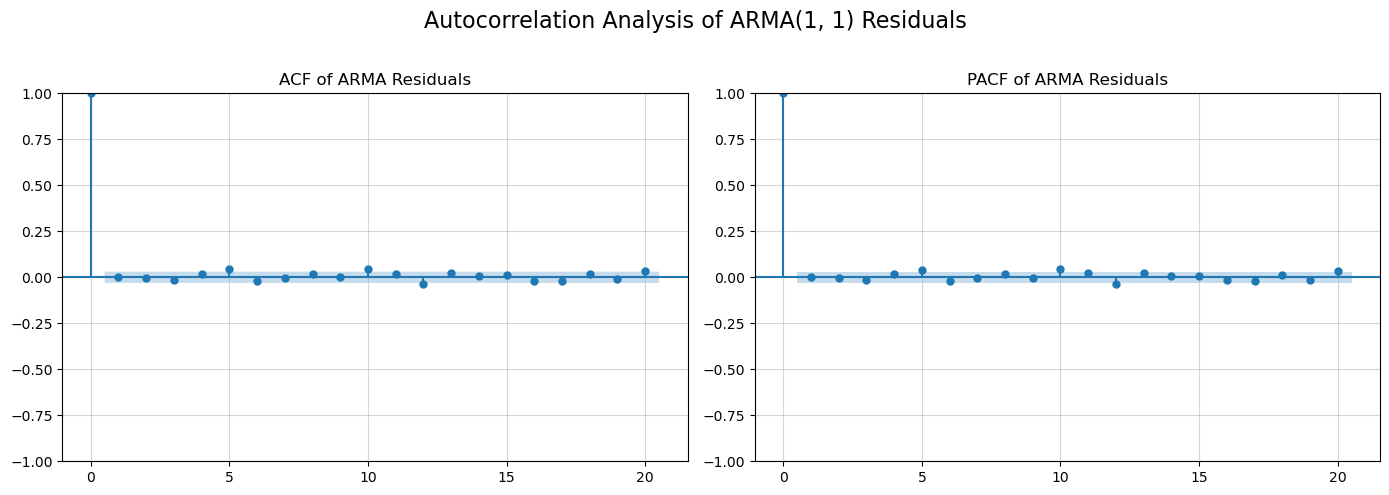

In [20]:
# EXTRACTING AND CHECKING RESIDUALS
residuals = arma_results.resid

#LB-test on residuals
lb_test_resid = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print('\nljung-box test on ARMA(1, 1) residuals')
print(lb_test_resid)

if all(lb_test_resid['lb_pvalue'] > 0.05):
    print('\nresiduals appear to be white noise (no significant autocorrelation)')
    print('can now proceed to model the variance using GARCH')
else:
    print('\nat least one p-value is <= 0.05. linear dependence remains. consider a higher ARMA model')
print('-' * 60)

# plotting acf and pacf for residuals
fig, axes = plt.subplots(1, 2, figsize=(14,5))
plot_acf(residuals, lags=20, ax=axes[0], title='ACF of ARMA Residuals')
axes[0].grid(True, alpha=0.5)

plot_pacf(residuals, lags=20, ax=axes[1], title='PACF of ARMA Residuals')
axes[1].grid(True, alpha=0.5)

plt.suptitle('Autocorrelation Analysis of ARMA(1, 1) Residuals', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
#Since the ARMA(1,1) only solved the Lag 1 dependence, 
# need a new model that addresses the remaining dependence, especially at Lag 10.

# try AUTOMATIC ARMA selection

In [21]:
from pmdarima import auto_arima
from arch import arch_model
import warnings
warnings.filterwarnings("ignore") # Suppress warnings

In [24]:
best_model = auto_arima(
    returns,
    d=0,             # Integrated order d=0 for ARMA
    max_p=5,
    max_q=5,
    m=1,             # m=1 for non-seasonal
    seasonal=False,
    stepwise=True,   # Faster search
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic' # Prioritize BIC for more parsimonious models
)

print(f"\nOptimal ARMA Order: ARIMA{best_model.order}")
print(best_model.summary())


Optimal ARMA Order: ARIMA(1, 0, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4139
Model:               SARIMAX(1, 0, 0)   Log Likelihood               16338.352
Date:                Wed, 26 Nov 2025   AIC                         -32672.705
Time:                        15:01:43   BIC                         -32660.048
Sample:                             0   HQIC                        -32668.226
                               - 4139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1917      0.005    -38.419      0.000      -0.202      -0.182
sigma2      2.181e-05   1.95e-07    111.611      0.000    2.14e-05    2.22e-05
Ljung-Box (L1) (

In [25]:
# EXTRACTING AND CHECKING THE RESIDUALS
residuals_final = pd.Series(best_model.resid(), index=returns.index)

lb_test_residuals_final = acorr_ljungbox(residuals_final, lags=[10, 20], return_df=True)
print("\nFinal Ljung-Box Test on Residuals")
print(lb_test_residuals_final)

if all(lb_test_residuals_final['lb_pvalue'] > 0.05):
    print("Residuals are confirmed as white noise in the mean.")
else:
    print("Residuals still contain linear dependence. Proceed with caution.")
print("-" * 60)


Final Ljung-Box Test on Residuals
      lb_stat  lb_pvalue
10  20.768154   0.022770
20  40.561604   0.004239
Residuals still contain linear dependence. Proceed with caution.
------------------------------------------------------------


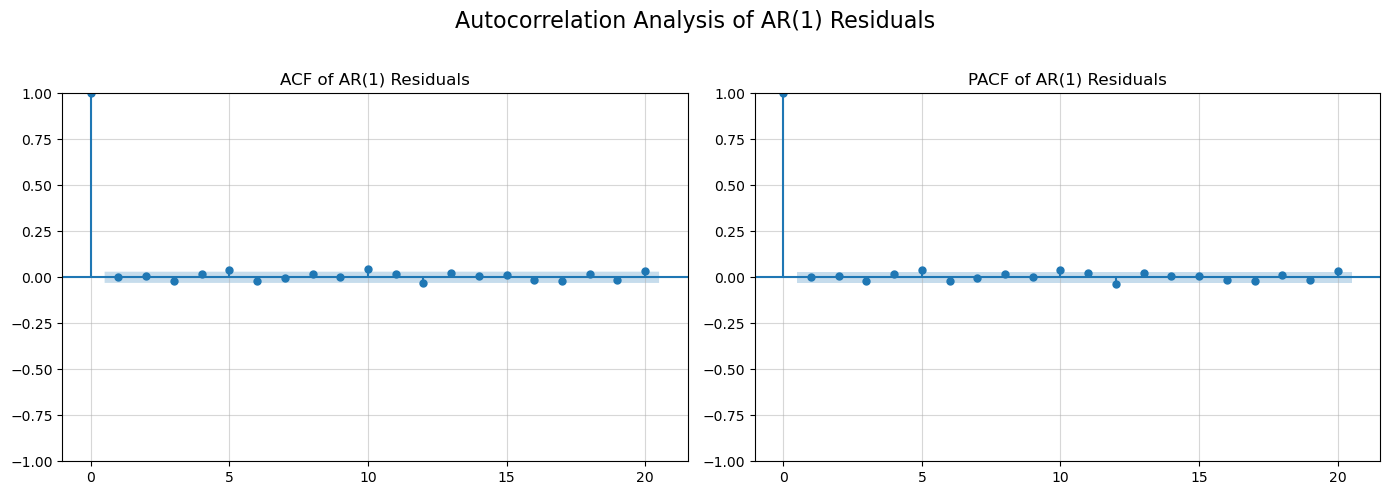

In [26]:


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
plot_acf(residuals_final, lags=20, ax=axes[0], title='ACF of AR(1) Residuals')
axes[0].grid(True, alpha=0.5)

# PACF Plot
plot_pacf(residuals_final, lags=20, ax=axes[1], title='PACF of AR(1) Residuals')
axes[1].grid(True, alpha=0.5)

plt.suptitle('Autocorrelation Analysis of AR(1) Residuals', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# THE PLOTS DONT HAVE SPIKES, SO WHY THERE IS DEPENDENCY IN THE TEST?

#The discrepancy exists because the ACF and PACF plots visually assess the individual significance of each lag, 
# while the Ljung-Box test assesses the joint significance of a group of lags.

#Why the Discrepancy?

#Even if every single lag falls within the 95% confidence band, there's a 5% chance for each lag that it's actually non-zero. 
# When you look at 10 or 20 lags, the probability of at least one non-zero autocorrelation being present somewhere in the group is much higher than 5%.

#The Ljung-Box test is designed to catch this subtle, collective effect of many small, non-zero correlations that might be missed by just looking at the individual spikes.

In [ ]:
#Since the Ljung-Box test failed, you must conclude that the ARMA(1,1) model has not fully whitened the residuals. You still have:

#Remaining Linear Dependence: 
# The Ljung-Box failure (p-values 0.024 and 0.004) suggests the mean model needs adjustment 
# (as discussed, an AR(1) might be better, or perhaps an ARMA(2,1)).

#Confirmed Heteroskedasticity: The Prob(H) of 0.00 strongly indicates that 
# the variance is still time-dependent and must be modeled with a GARCH process.

In [ ]:
# ANALYSIS OF AR(1) RESULTS

# The autocorrelation analysis of your AR(1) residuals confirms a common challenge in financial time series: 
# while the visual plots appear fine, the statistical test still flags remaining dependence.

#PACF & ACF
#No individual spikes (lags 1 through 20) fall outside the blue shaded confidence band.
#Visually, the residuals appear to be white noise. This means the AR(1) model successfully 
# removed the major linear structure (the Lag 1 spike) from the original returns.

#Statistical Inspection (Ljung-Box Test)
# Since the p-values are less than 0.05, we must reject the null hypothesis that the autocorrelations are simultaneously zero.

#In financial econometrics, the priority now shifts to the highly significant volatility clustering that was confirmed in the AR(1) model summary (Prob(H) = 0.00).

In [ ]:
#The next step is to fit a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model to the residuals. This combined model will be an AR(1)-GARCH$(p, q)$.